In [1]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Загружаем тестовые данные

In [2]:
test_df = pd.read_excel("data/excel/test.xlsx")

2. Загружаем обученную модель

In [3]:
model = CatBoostRegressor()
model.load_model("catboostmodel_Marin.cbm")

test_df["dt"] = pd.to_datetime(test_df["dt"], dayfirst=True)
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

3. Подготавливаем признаки

In [4]:
# Создаём признаки
if 'Price' in test_df.columns:
    test_df["Price_source"] = test_df["Price"].shift(1)

    # Заполняем NaN
    test_df["Price_source"] = test_df["Price_source"].interpolate(method='linear')
    test_df["Price_source"] = test_df["Price_source"].fillna(test_df["Price_source"].mean())

4. Выбираем признаки и делаем прогноз

In [5]:
X_test = test_df[['Price_source']].iloc[1:, :]

test_df = test_df.iloc[1:, :]
test_df["Predicted_Price"] = np.expm1(model.predict(X_test))

5. Определяем N недель закупки

In [6]:
def calculate_weeks(row):
    if row["Predicted_Price"] > row["Price"] * 1.02:
        return 6  # Цена растёт (+2%)
    elif row["Predicted_Price"] > row["Price"]:
        return 4  # Незначительный рост
    elif row["Predicted_Price"] < row["Price"] * 0.98:
        return 1  # Цена падает (-2%)
    else:
        return 3  # Стабильная цена → средний объём закупки

test_df["Weeks_to_Procure"] = test_df.apply(calculate_weeks, axis=1)

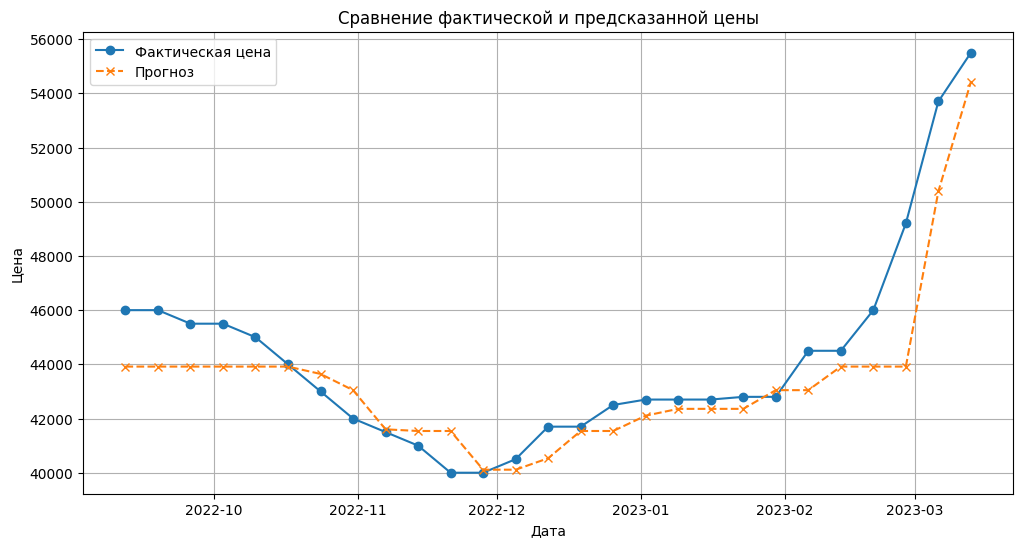

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(test_df["dt"], test_df["Price"], label="Фактическая цена", marker='o')
plt.plot(test_df["dt"], test_df["Predicted_Price"], label="Прогноз", linestyle='dashed', marker='x')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение фактической и предсказанной цены")
plt.grid()
plt.show()

6. Сохраняем результаты

In [8]:
test_df.to_excel("predicted_procurement.xlsx", index=False)
print("Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx")

Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx
